<h1>Prepare Environment</h1>

In [44]:
from data_processing.Augmentation import *
from data_processing.helper import *

In [45]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
import time

<h1>Loading dataset</h1>

In [47]:
DATA_DIR = './CamVid/'

In [48]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [49]:
# Lets look at data we have
"""
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
"""
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'])

image, mask = dataset[5] # get some sample

In [50]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

In [51]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Augmentation</h1>

In [52]:
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'], 
                  augmentation=get_training_augmentation())

In [53]:
image, mask = dataset[20] # get some sample

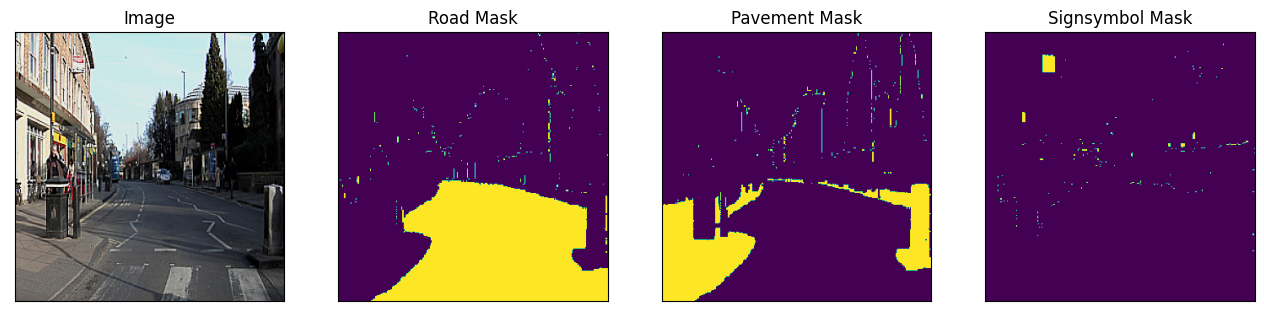

In [54]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

In [55]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Segmentation Model Training</h1>

In [56]:
import segmentation_models as sm
sm.set_framework('tf.keras')

In [57]:
BACKBONE = 'inceptionv3'
BATCH_SIZE = 4
CLASSES = ['road', 'pavement', 'signsymbol','car', 'pedestrian', 'bicyclist']
LR = 0.0001

# Set number of epochs
EPOCHS = 250

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [58]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [59]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 3,4,5,6,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss = total_loss, metrics = metrics)

In [60]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_188 (Conv2D)            (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_188 (Batch  (None, None, None,   96         ['conv2d_188[0][0]']             
 Normalization)                 32)                                                         

In [61]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [62]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [63]:
from tensorflow.keras.callbacks import EarlyStopping
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoint/inceptionv3_Unet.h5', monitor='val_loss',save_weights_only=True, save_best_only=True, mode='min')
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1, factor=0.5, min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=STOPPING_PATIENCE, verbose=1, restore_best_weights=True)


In [64]:
# train model
pre_train = time.time()
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=[learning_rate,early_stopping,checkpoint], 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)
time_training = time.time() - pre_train

/tmp/ipykernel_38719/1794659408.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
91/91 [==============================] - 94s 968ms/step - loss: 0.8309 - iou_score: 0.1643 - f1-score: 0.2165 - val_loss: 0.7470 - val_iou_score: 0.2784 - val_f1-score: 0.3438 - lr: 1.0000e-04
Epoch 2/250
91/91 [==============================] - 88s 969ms/step - loss: 0.6886 - iou_score: 0.3691 - f1-score: 0.4362 - val_loss: 0.6202 - val_iou_score: 0.3892 - val_f1-score: 0.4431 - lr: 1.0000e-04
Epoch 3/250
91/91 [==============================] - 87s 956ms/step - loss: 0.6368 - iou_score: 0.3980 - f1-score: 0.4595 - val_loss: 0.6213 - val_iou_score: 0.3729 - val_f1-score: 0.4285 - lr: 1.0000e-04
Epoch 4/250
91/91 [==============================] - 88s 964ms/step - loss: 0.5938 - iou_score: 0.4139 - f1-score: 0.4721 - val_loss: 0.5730 - val_iou_score: 0.4040 - val_f1-score: 0.4549 - lr: 1.0000e-04
Epoch 5/250
91/91 [==============================] - 88s 966ms/step - loss: 0.5632 - iou_score: 0.4300 - f1-score: 0.4865 - val_loss: 0.5384 - val_iou_score: 0.4221 - val_f1-score:

Epoch 40/250
91/91 [==============================] - 87s 956ms/step - loss: 0.3628 - iou_score: 0.5942 - f1-score: 0.6842 - val_loss: 0.3326 - val_iou_score: 0.6286 - val_f1-score: 0.7255 - lr: 5.0000e-05
Epoch 41/250
91/91 [==============================] - ETA: 0s - loss: 0.3601 - iou_score: 0.5978 - f1-score: 0.6892
Epoch 00041: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
91/91 [==============================] - 87s 953ms/step - loss: 0.3601 - iou_score: 0.5978 - f1-score: 0.6892 - val_loss: 0.3248 - val_iou_score: 0.6323 - val_f1-score: 0.7301 - lr: 5.0000e-05
Epoch 42/250
91/91 [==============================] - 87s 953ms/step - loss: 0.3660 - iou_score: 0.5948 - f1-score: 0.6837 - val_loss: 0.3264 - val_iou_score: 0.6311 - val_f1-score: 0.7266 - lr: 2.5000e-05
Epoch 43/250
91/91 [==============================] - 87s 953ms/step - loss: 0.3594 - iou_score: 0.5990 - f1-score: 0.6896 - val_loss: 0.3229 - val_iou_score: 0.6331 - val_f1-score: 0.7304 - lr: 2.50

91/91 [==============================] - 87s 953ms/step - loss: 0.3486 - iou_score: 0.6092 - f1-score: 0.6986 - val_loss: 0.3156 - val_iou_score: 0.6381 - val_f1-score: 0.7366 - lr: 3.1250e-06
Epoch 77/250
91/91 [==============================] - ETA: 0s - loss: 0.3445 - iou_score: 0.6112 - f1-score: 0.7014
Epoch 00077: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
91/91 [==============================] - 87s 953ms/step - loss: 0.3445 - iou_score: 0.6112 - f1-score: 0.7014 - val_loss: 0.3172 - val_iou_score: 0.6367 - val_f1-score: 0.7352 - lr: 3.1250e-06
Epoch 78/250
91/91 [==============================] - 87s 957ms/step - loss: 0.3454 - iou_score: 0.6119 - f1-score: 0.7006 - val_loss: 0.3169 - val_iou_score: 0.6368 - val_f1-score: 0.7352 - lr: 1.5625e-06
Epoch 79/250
91/91 [==============================] - 87s 953ms/step - loss: 0.3464 - iou_score: 0.6103 - f1-score: 0.6996 - val_loss: 0.3165 - val_iou_score: 0.6374 - val_f1-score: 0.7358 - lr: 1.5625e-06
Epoch 8

<h1>Model Evaluation</h1>

In [65]:
print('Time training:{} (s)'.format(time_training))

Time training:8913.76966381073 (s)


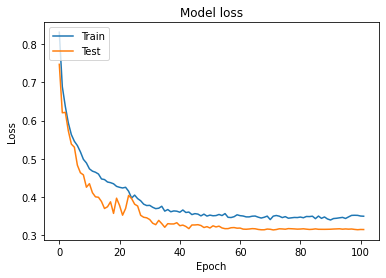

In [66]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

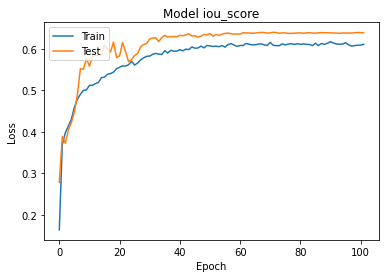

In [67]:
# Plot training & validation loss values
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [68]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [69]:
# load best weights
model.load_weights('./checkpoint/inceptionv3_Unet.h5')

In [70]:
scores  = model.evaluate_generator(test_dataloader)
print("Loss:{:.5}".format(scores[0]))
for metric,value in zip(metrics,scores[1:]):
    print("mean {}:{:.5}".format(metric.__name__,value))

/tmp/ipykernel_38719/2477453485.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores  = model.evaluate_generator(test_dataloader)


Loss:0.44307
mean iou_score:0.52732
mean f1-score:0.60329


In [71]:
df = pd.DataFrame({'backbone':[BACKBONE],'model':['Unet'],'Time_training':[time_training],
                   'loss':[scores[0]],'Iou_score':[scores[1]]})

In [72]:
df

backbone model  Time_training      loss  Iou_score
0  inceptionv3  Unet    8913.769664  0.443069   0.527323

In [73]:
data = pd.read_excel('Evaluation_model.xlsx')
data = data[['backbone','model','Time_training','loss','Iou_score']]
data

Empty DataFrame
Columns: [backbone, model, Time_training, loss, Iou_score]
Index: []

In [74]:
df = pd.concat([df,data],axis=0)
df

backbone model  Time_training      loss  Iou_score
0  inceptionv3  Unet    8913.769664  0.443069   0.527323

In [75]:
df.to_excel('Evaluation_model.xlsx')

<h1>Evaluation on Test</h1>

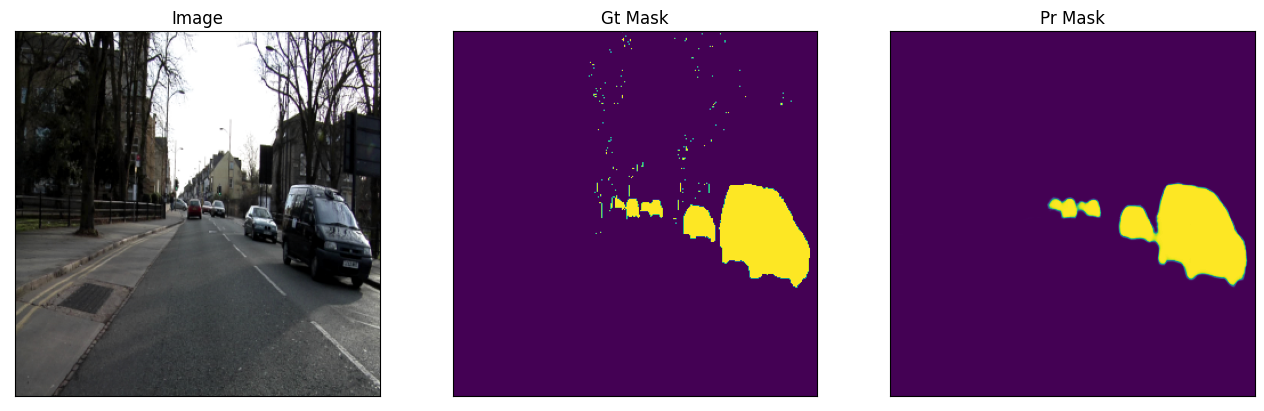

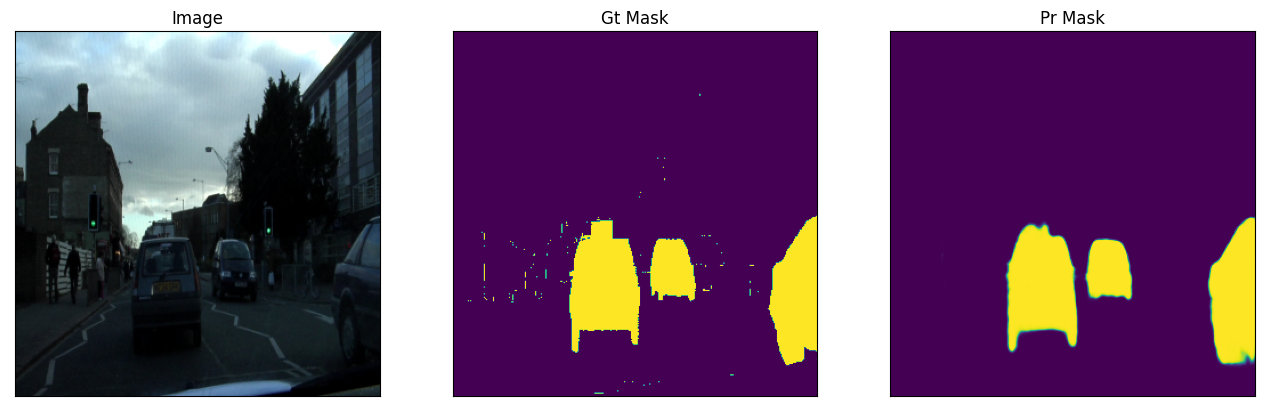

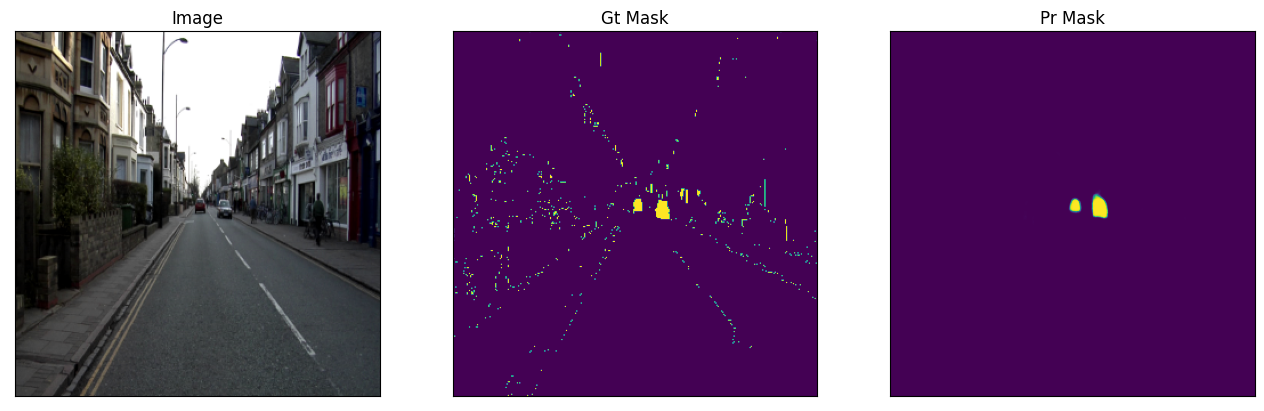

In [76]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[...,3].squeeze(),
        pr_mask=pr_mask[...,3].squeeze(),
    )